## Running Detectron 2 on Common Dataset



**Install Detectron2**

In [ ]:
!python -m pip install pyyaml==5.1
import sys, os, distutils.core
# Note: This is a faster way to install detectron2 in Colab, but it does not include all functionalities (e.g. compiled operators).
# See https://detectron2.readthedocs.io/tutorials/install.html for full installation instructions
!git clone 'https://github.com/facebookresearch/detectron2'
dist = distutils.core.run_setup("./detectron2/setup.py")
!python -m pip install {' '.join([f"'{x}'" for x in dist.install_requires])}
sys.path.insert(0, os.path.abspath('./detectron2'))


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 274.2/274.2 kB 1.7 MB/s eta 0:00:00
  error: subprocess-exited-with-error
  
  × python setup.py egg_info did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  Preparing metadata (setup.py) ... error
error: metadata-generation-failed

× Encountered error while generating package metadata.
╰─> See above for output.

note: This is an issue with the package mentioned above, not pip.
hint: See above for details.
Cloning into 'detectron2'...
remote: Enumerating objects: 15671, done.
remote: Counting objects: 100% (394/394), done.
remote: Compressing objects: 100% (293/293), done.
remote: Total 15671 (delta 174), reused 274 (delta 101), pack-reused 15277
Receiving objects: 100% (15671/15671), 6.50 MiB | 6.67 MiB/s, done.
Resolving deltas: 100% (11290/11290), done.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.2/50.2 kB 572.1 kB/s eta 0:

In [ ]:
import torch, detectron2
!nvcc --version
TORCH_VERSION = ".".join(torch.__version__.split(".")[:2])
CUDA_VERSION = torch.__version__.split("+")[-1]
print("torch: ", TORCH_VERSION, "; cuda: ", CUDA_VERSION)
print("detectron2:", detectron2.__version__)

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2023 NVIDIA Corporation
Built on Tue_Aug_15_22:02:13_PDT_2023
Cuda compilation tools, release 12.2, V12.2.140
Build cuda_12.2.r12.2/compiler.33191640_0
torch:  2.2 ; cuda:  cu121
detectron2: 0.6


In [ ]:
# Some basic setup:
# Setup detectron2 logger
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

# import some common libraries
import numpy as np
import os, json, cv2, random
from google.colab.patches import cv2_imshow

# import some common detectron2 utilities
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog
import matplotlib.pyplot as plt


The default models are trained on natural images so let us go ahead and load a natural image to see if detectron is working. **We will run a pre-trained model on this image.**

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


We create a detectron2 config and a detectron2 DefaultPredictor to run inference on this image.

In [ ]:
cfg_base = get_cfg()
cfg_base.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_50_C4_1x.yaml"))
cfg_base.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.9  # set threshold for this model
cfg_base.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-InstanceSegmentation/mask_rcnn_R_50_C4_1x.yaml")
predictor_base = DefaultPredictor(cfg_base)

[05/03 23:31:06 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from https://dl.fbaipublicfiles.com/detectron2/COCO-InstanceSegmentation/mask_rcnn_R_50_C4_1x/137259246/model_final_9243eb.pkl ...


model_final_9243eb.pkl: 144MB [00:00, 173MB/s]                           


In [ ]:
sci_im = cv2.imread("/content/drive/MyDrive/Computer Vision Project/datasets/construction/train/BVLOS_mission_over_3_mines-11-_png.rf.b9017963d428ab7f1a1cdb7241e38908.jpg")

Now that we know the model is working on a natural image, let us test on a scientific image.

Let us make some predictions. Remember that the model mask_rcnn_R_50_FPN_3x has no idea about our sample and did not get trained on cells or mitochondria or on any scientific images.

In [ ]:
sci_outputs = predictor_base(sci_im)
sci_v = Visualizer(sci_im[:, :, ::-1], MetadataCatalog.get(cfg_base.DATASETS.TRAIN[0]))
sci_out = sci_v.draw_instance_predictions(sci_outputs["instances"].to("cpu"))
cv2_imshow(sci_out.get_image()[:, :, ::-1])

Of course, our cells are mislabeled as Tie, Pizza, etc. Let us train on a custom dataset.

# Train on a custom dataset

Import the necessary function to register datasets in the COCO format. Let us register both the training and validation datasets. Please note that we are working with training (and validation) data that is is the coco format where we have a single JSON file that describes all the annotations from all training images. <p>
Here, we are naming our training data as 'my_dataset_train' and the validation data as 'my_dataset_val'.



In [ ]:
from detectron2.data import DatasetCatalog

dataset_name = 'my_dataset_train_house'
val_name = 'my_dataset_val_house'
test_name = 'my_dataset_test_house'
if dataset_name in DatasetCatalog.list():
    print("removing previous instances")
    MetadataCatalog.remove(dataset_name)
    MetadataCatalog.remove(test_name)
    MetadataCatalog.remove(val_name)
    DatasetCatalog.remove(dataset_name)
    DatasetCatalog.remove(test_name)
    DatasetCatalog.remove(val_name)


removing perv


In [ ]:
from detectron2.data.datasets import register_coco_instances
register_coco_instances(dataset_name, {}, "/content/drive/MyDrive/Computer Vision Project/datasets/construction/train/_annotations.coco.json", "/content/drive/MyDrive/Computer Vision Project/datasets/construction/train")
register_coco_instances(val_name, {}, "/content/drive/MyDrive/Computer Vision Project/datasets/construction/valid/_annotations.coco.json", "/content/drive/MyDrive/Computer Vision Project/datasets/construction/valid")
register_coco_instances(test_name, {}, "/content/drive/MyDrive/Computer Vision Project/datasets/construction/test/_annotations.coco.json", "/content/drive/MyDrive/Computer Vision Project/datasets/construction/test")



Let us extract the metadata and dataset dictionaries for both training and validation datasets. These can be used later for other purposes, like visualization, model training, evaluation, etc. We will see a visualization example right away.

In [ ]:
train_metadata = MetadataCatalog.get("my_dataset_train_house")
train_dataset_dicts = DatasetCatalog.get("my_dataset_train_house")

WARNING [04/28 23:17:15 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[04/28 23:17:15 d2.data.datasets.coco]: Loaded 11 images in COCO format from /content/drive/MyDrive/Computer Vision Project/datasets/construction/train/_annotations.coco.json


In [ ]:
nn = []
train_dataset_dicts
for each in train_dataset_dicts:
  # print(each)
  for ann in each['annotations']:

    nn.append(ann['category_id'])
print(set(nn))

{1}


In [ ]:
test_metadata = MetadataCatalog.get("my_dataset_test_house")
test_dataset_dicts = DatasetCatalog.get("my_dataset_test_house")


WARNING [04/28 23:55:38 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[04/28 23:55:38 d2.data.datasets.coco]: Loaded 1 images in COCO format from /content/drive/MyDrive/Computer Vision Project/datasets/construction/test/_annotations.coco.json


In [ ]:
val_metadata = MetadataCatalog.get("my_dataset_val_house")
val_dataset_dicts = DatasetCatalog.get("my_dataset_val_house")


WARNING [04/28 23:17:19 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[04/28 23:17:19 d2.data.datasets.coco]: Loaded 3 images in COCO format from /content/drive/MyDrive/Computer Vision Project/datasets/construction/valid/_annotations.coco.json


In [ ]:
from matplotlib import pyplot as plt

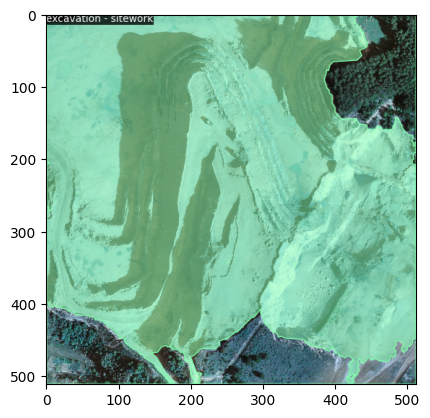

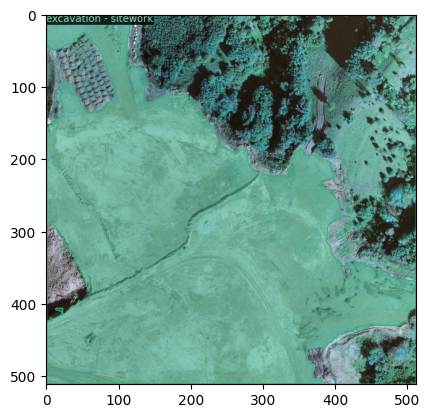

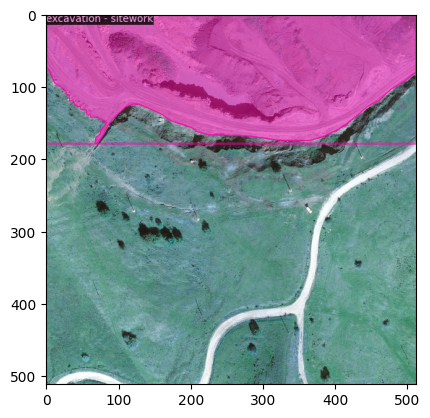

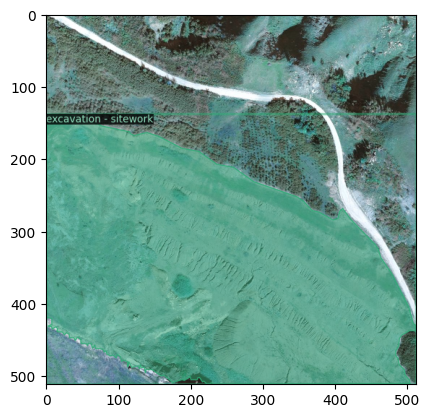

In [ ]:
# Visualize some random samples
for i,d in enumerate(train_dataset_dicts):
    img = cv2.imread(d["file_name"])
    visualizer = Visualizer(img[:, :, ::-1], metadata=train_metadata, scale=0.5)
    vis = visualizer.draw_dataset_dict(d)
    plt.imshow(vis.get_image()[:, :, ::-1])
    plt.show()
    if i>2:
        break


# Train

Now we are ready to train a Mask R-CNN model using the Detectron2 library. We start by setting up a configuration file (.cfg) for the model. The configuration file contains many details including the output directory path, training dataset information, pre-trained weights, base learning rate, maximum number of iterations, etc.

In [ ]:
from detectron2.engine import DefaultTrainer

cfg = get_cfg()
cfg.OUTPUT_DIR = "/content/drive/MyDrive/Detectron/models"
# https://github.com/facebookresearch/detectron2/blob/main/configs/COCO-InstanceSegmentation/mask_rcnn_X_101_32x8d_FPN_3x.yaml
cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_50_C4_1x.yaml"))
cfg.DATASETS.TRAIN = ("my_dataset_train_house",)
cfg.DATASETS.TEST = ()
cfg.DATALOADER.NUM_WORKERS = 3
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-InstanceSegmentation/mask_rcnn_R_50_C4_1x.yaml")  # Let training initialize from model zoo
cfg.SOLVER.IMS_PER_BATCH = 2  # This is the real "batch size" commonly known to deep learning people
cfg.SOLVER.BASE_LR = 0.0005  # pick a good LR
cfg.SOLVER.MAX_ITER = 100    # 1000 iterations seems good enough for this dataset
cfg.SOLVER.STEPS = []        # do not decay learning rate
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 256   # Default is 512, using 256 for this dataset.
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 3  # We have 4 classes.
# NOTE: this config means the number of classes, without the background. Do not use num_classes+1 here.

os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
trainer = DefaultTrainer(cfg) #Create an instance of of DefaultTrainer with the given congiguration
trainer.resume_or_load(resume=False) #Load a pretrained model if available (resume training) or start training from scratch if no pretrained model is available


[04/29 00:00:39 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): ResNet(
    (stem): BasicStem(
      (conv1): Conv2d(
        3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
        (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
      )
    )
    (res2): Sequential(
      (0): BottleneckBlock(
        (shortcut): Conv2d(
          64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False
          (norm): FrozenBatchNorm2d(num_features=256, eps=1e-05)
        )
        (conv1): Conv2d(
          64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
        (conv2): Conv2d(
          64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
        (conv3): Conv2d(
          64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False
          (norm): FrozenBatchNorm2d(num_features=256, eps=1e-05)
 

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 3 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
roi_heads.box_predictor.bbox_pred.{bias, weight}
roi_heads.box_predictor.cls_score.{bias, weight}
roi_heads.mask_head.predictor.{bias, weight}


Train

In [ ]:
trainer.train() #Start the training process

[04/29 00:00:42 d2.engine.train_loop]: Starting training from iteration 0


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


[04/29 00:01:00 d2.utils.events]:  eta: 0:01:10  iter: 19  total_loss: 2.516  loss_cls: 1.199  loss_box_reg: 0.2746  loss_mask: 0.691  loss_rpn_cls: 0.2649  loss_rpn_loc: 0.09221    time: 0.8810  last_time: 0.8729  data_time: 0.0316  last_data_time: 0.0062   lr: 9.5405e-05  max_mem: 2890M
[04/29 00:01:17 d2.utils.events]:  eta: 0:00:52  iter: 39  total_loss: 1.485  loss_cls: 0.3091  loss_box_reg: 0.2845  loss_mask: 0.6455  loss_rpn_cls: 0.1505  loss_rpn_loc: 0.07749    time: 0.8839  last_time: 0.9232  data_time: 0.0095  last_data_time: 0.0056   lr: 0.00019531  max_mem: 2890M
[04/29 00:01:35 d2.utils.events]:  eta: 0:00:34  iter: 59  total_loss: 1.189  loss_cls: 0.1376  loss_box_reg: 0.2554  loss_mask: 0.5431  loss_rpn_cls: 0.1327  loss_rpn_loc: 0.0663    time: 0.8755  last_time: 0.8507  data_time: 0.0106  last_data_time: 0.0101   lr: 0.0002952  max_mem: 2890M
[04/29 00:01:53 d2.utils.events]:  eta: 0:00:17  iter: 79  total_loss: 0.8757  loss_cls: 0.1017  loss_box_reg: 0.2574  loss_mask

Save the config file, for potential future use

In [ ]:
import yaml
config_yaml_path = "/content/drive/MyDrive/Detectron/models/config.yaml"
with open(config_yaml_path, 'w') as file:
    yaml.dump(cfg, file)

# Inference & evaluation using the trained model

In [ ]:
# Inference should use the config with parameters that are used in training
# cfg now already contains everything we've set previously. We changed it a little bit for inference:
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")  # path to the model we just trained
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5   # set a custom testing threshold
predictor = DefaultPredictor(cfg)

[04/29 00:02:17 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from /content/drive/MyDrive/Detectron/models/model_final.pth ...


Verify segmentation on random validation images

Check average precision and recall. (Need more validation data than just 2 images with handful of annotations)

In [ ]:
from detectron2.evaluation import COCOEvaluator, inference_on_dataset
from detectron2.data import build_detection_test_loader
evaluator = COCOEvaluator("my_dataset_val_house", output_dir="./output")
val_loader = build_detection_test_loader(cfg, "my_dataset_val_house")
print(inference_on_dataset(predictor.model, val_loader, evaluator))
# another equivalent way to evaluate the model is to use `trainer.test`

[04/29 00:02:21 d2.evaluation.coco_evaluation]: Fast COCO eval is not built. Falling back to official COCO eval.
WARNING [04/29 00:02:21 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[04/29 00:02:21 d2.data.datasets.coco]: Loaded 3 images in COCO format from /content/drive/MyDrive/Computer Vision Project/datasets/construction/valid/_annotations.coco.json
[04/29 00:02:21 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in inference: [ResizeShortestEdge(short_edge_length=(800, 800), max_size=1333, sample_style='choice')]
[04/29 00:02:21 d2.data.common]: Serializing the dataset using: <class 'detectron2.data.common._TorchSerializedList'>
[04/29 00:02:21 d2.data.common]: Serializing 3 elements to byte tensors and concatenating them all ...
[04/29 00:02:21 d2.data.common]: Serialized dataset takes 0.00 MiB
[04/29 00:02:21 d2.evaluation.evaluator]: Start inference on 3 batches


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 3 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


[04/29 00:02:23 d2.evaluation.evaluator]: Total inference time: 0:00:00.281990 (0.281990 s / iter per device, on 1 devices)
[04/29 00:02:23 d2.evaluation.evaluator]: Total inference pure compute time: 0:00:00 (0.181307 s / iter per device, on 1 devices)
[04/29 00:02:23 d2.evaluation.coco_evaluation]: Preparing results for COCO format ...
[04/29 00:02:23 d2.evaluation.coco_evaluation]: Saving results to ./output/coco_instances_results.json
[04/29 00:02:23 d2.evaluation.coco_evaluation]: Evaluating predictions with official COCO API...
Loading and preparing results...
DONE (t=0.00s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.00s).
Accumulating evaluation results...
DONE (t=0.02s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.332
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.505
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.257
 Average

**Load a new image and segment it.**

In [ ]:
random.seed(40)

# Sample 2 random datasets from validation set
samples = random.sample(val_dataset_dicts, 3)
i =1

for d in samples:


    fig, axs = plt.subplots(1, 3, figsize=(18, 6))  # 1 row, 3 columns
    img = cv2.imread(d["file_name"])

    fig.text(0.5, 0.95, f'Example {i}', ha='center', va='center', fontsize=16)

    # img = cv2.imread(d["file_name"])
    visualizer = Visualizer(img[:, :, ::-1], metadata=train_metadata, scale=0.5)
    vis = visualizer.draw_dataset_dict(d)
    axs[0].imshow(vis.get_image()[:, :, ::-1])
    # plt.show()

    # Original Image
    # axs[0].imshow(img[:, :, ::-1])
    axs[0].set_title('Original Image')
    axs[0].axis('off')  # Hide axes ticks
    # Base Prediction
    outputs_base = predictor_base(img)
    vb = Visualizer(img[:, :, ::-1], metadata=val_metadata, scale=0.5)
    out_base = vb.draw_instance_predictions(outputs_base["instances"].to("cpu"))
    axs[1].imshow(out_base.get_image()[:, :, ::-1])
    axs[1].set_title('Base Prediction')
    axs[1].axis('off')
    # Prediction
    outputs = predictor(img)
    v = Visualizer(img[:, :, ::-1], metadata=val_metadata, scale=0.5)
    out = v.draw_instance_predictions(outputs["instances"].to("cpu"))
    axs[2].imshow(out.get_image()[:, :, ::-1])
    axs[2].set_title('Prediction')
    axs[2].axis('off')
    i+=1



    plt.show()

Output hidden; open in https://colab.research.google.com to view.

**Process multiple images in a directory and save the results in an output directory**

In [ ]:
# R50-C4
output_directory = "/content/drive/MyDrive/Computer Vision Project/datasets/houses/test_results_R50-C4"  # Replace this with the path to your desired output directory

if not os.path.exists(output_directory):
    os.makedirs(output_directory)

In [ ]:
# Directory path to the input images folder
input_images_directory = "/content/drive/MyDrive/Computer Vision Project/datasets/houses/train"

# Loop over the images in the input folder
for image_filename in os.listdir(input_images_directory):
    if image_filename.endswith(".jpg") or image_filename.endswith(".png"):
        image_path = os.path.join(input_images_directory, image_filename)
        new_im = cv2.imread(image_path)

        # Perform prediction on the new image
        outputs = predictor(new_im)  # Format is documented at https://detectron2.readthedocs.io/tutorials/models.html#model-output-format

        # We can use `Visualizer` to draw the predictions on the image.
        v = Visualizer(new_im[:, :, ::-1], metadata=train_metadata)
        out = v.draw_instance_predictions(outputs["instances"].to("cpu"))

        # Create the output filename with _result extension
        result_filename = os.path.splitext(image_filename)[0] + "_result.png"
        output_path = os.path.join(output_directory, result_filename)

        # Save the segmented image
        cv2.imwrite(output_path, out.get_image()[:, :, ::-1])

print("Segmentation of all images completed.")

Segmentation of all images completed.
